In [1]:
import numpy as np
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, Norm_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, Norm_Iso2DGaussianFitter

import os

from os.path import join as opj

import scipy.io

import nibabel as nib

import matplotlib.pyplot as plt

from nilearn.maskers import NiftiMasker
from nilearn import image

import pickle

/home/mayaaj90/anaconda3/envs/py38prf/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
if os.getcwd() != '/home/mayaaj90/projects/project-00-7t-pipeline-dev/code/analysis-scripts/python':
    os.chdir('/home/mayaaj90/projects/project-00-7t-pipeline-dev/code/analysis-scripts/python')

In [3]:
os.getcwd()

'/home/mayaaj90/projects/project-00-7t-pipeline-dev/code/analysis-scripts/python'

In [4]:
n_procs = int(os.getenv('OMP_NUM_THREADS'))   
print(n_procs)

1


In [5]:
sub_id       = 0 #sys.argv[1]
hem_id       = 0 #sys.argv[2]

subject_list = ['sub-01','sub-02','sub-03','sub-04']
hem_list     = ['lh','rh']

proj_dir     = '/scratch/mayaaj90/project-00-7t-pipeline-dev/'
data_dir     = opj(proj_dir,'output','func','sliceTimeCorr',
                   '_subject_id_'+subject_list[sub_id])
bar1_file    = opj(data_dir,'_sess_id_task-bar_run-01_sess_nr_0_sess_nvol_124','atask-bar_run-01_roi_warp4D.nii')
bar2_file    = opj(data_dir,'_sess_id_task-bar_run-02_sess_nr_1_sess_nvol_124','atask-bar_run-02_roi_warp4D.nii')

meanFunc_file= opj(proj_dir,'output','func','meanFunc',
                   '_subject_id_'+subject_list[sub_id],'merged_func_mcf.nii_mean_reg.nii')


prfpy_output_dir = opj(proj_dir,'output','prfpy',subject_list[sub_id])
if not os.path.isdir(prfpy_output_dir):
    os.makedirs(prfpy_output_dir)
    
GM_file      = opj(prfpy_output_dir,
                   hem_list[hem_id]+'_GM_funcSpace.nii')
occ_file     = opj(prfpy_output_dir,
                  'funcSpaceOccipitalMask.nii')
    
grid_fit_file      = opj(prfpy_output_dir,hem_list[hem_id]+'_grid_fit.pckl')
iterative_fit_file = opj(prfpy_output_dir,hem_list[hem_id]+'_iterative_fit.pckl')
pRF_param_file     = opj(prfpy_output_dir,hem_list[hem_id]+'_pRF_params.pckl')

#/home/mayajas/scratch/project-00-7t-pipeline-dev/manualcorr/func/_subject_id_sub-01
#output/func/sliceTimeCorr/_subject_id_sub-01/_sess_id_task-bar_run-01_sess_nr_0_sess_nvol_12

In [6]:
GM_file

'/scratch/mayaaj90/project-00-7t-pipeline-dev/output/prfpy/sub-01/lh_GM_funcSpace.nii'

In [7]:
occ_file

'/scratch/mayaaj90/project-00-7t-pipeline-dev/output/prfpy/sub-01/funcSpaceOccipitalMask.nii'

# Creating stimulus object

Get stimulus aperture

In [8]:
project_dir  = '/home/mayaaj90/projects/project-00-7t-pipeline-dev/'
Ap_file      = os.path.join(project_dir,'code','stim-scripts','apertures','stimulus_bar.mat')

mat          = scipy.io.loadmat(Ap_file)

In [9]:
np.shape(mat["stim"])

(200, 200, 120)

Define screen size, distance, TR and aperture matrix

In [10]:
screen_size_cm     = 12.0
screen_distance_cm = 52.0
TR                 = 3.0
design_matrix      = mat["stim"]

In [11]:
import math 
max_ecc = math.atan(screen_size_cm/screen_distance_cm)/2
max_ecc_deg = math.degrees(max_ecc)

print("Max eccentricity of stimulus is "+str(round(max_ecc_deg,2)))

Max eccentricity of stimulus is 6.5


Define stimulus object

In [12]:
prf_stim = PRFStimulus2D(screen_size_cm=screen_size_cm,
                             screen_distance_cm=screen_distance_cm,
                             design_matrix=design_matrix,
                             TR=TR)

# Gaussian model fit

## Creating Gaussian model and fitter objects

In [13]:
# Input parameters of Iso2DGaussianModel
hrf                = None     # string, list or numpy.ndarray, optional
                              # HRF shape for this Model.
                              # Can be 'direct', which implements nothing (for eCoG or later convolution),
                              # a list or array of 3, which are multiplied with the three spm HRF basis functions,
                              # and an array already sampled on the TR by the user.
                              # (the default is None, which implements standard spm HRF)
filter_predictions = False    # boolean, optional
                              # whether to high-pass filter the predictions, default False
filter_type        = None
filter_params      = None
normalize_RFs      = False    # whether or not to normalize the RF volumes (generally not needed).

# Input parameters of Iso2DGaussianFitter
n_jobs             = n_procs  # int, optional
                              # number of jobs to use in parallelization (iterative search), by default 1
fit_hrf            = False    # boolean, optional
                              # Whether or not to fit two extra parameters for hrf derivative and
                              # dispersion. The default is False.

In [14]:
gg = Iso2DGaussianModel(stimulus=prf_stim)

# gg = Iso2DGaussianModel(stimulus=prf_stim,
#                           hrf=hrf,
#                           filter_predictions=filter_predictions,
#                           filter_type=filter_type,
#                           filter_params=filter_params,
#                           normalize_RFs=normalize_RFs)

#gf = Iso2DGaussianFitter(data=data, model=gg, n_jobs=n_jobs, fit_hrf=fit_hrf)

Get func data

In [15]:
bar1 = nib.load(bar1_file)
bar2 = nib.load(bar2_file)

# bar1_data = bar1.get_fdata()
# bar2_data = bar2.get_fdata()

In [16]:
occ = nib.load(occ_file)

In [17]:
GM = nib.load(GM_file)

In [18]:
meanFunc = nib.load(meanFunc_file)

Do masking

In [19]:
mask = image.math_img("np.logical_and(img1, img2)", img1=occ, img2=GM)

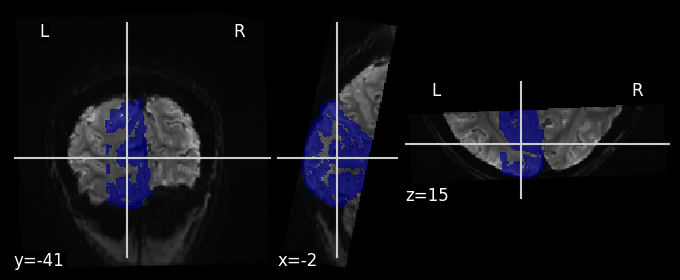

In [20]:
# Visualize it as an ROI
from nilearn.plotting import plot_roi
plot_roi(mask,meanFunc)

In [21]:
masker = NiftiMasker(mask_img=mask)

In [22]:
masked_bar1 = masker.fit_transform(bar1)
masked_bar2 = masker.fit_transform(bar2)

In [23]:
masked_bar1 = np.rot90(masked_bar1)
masked_bar2 = np.rot90(masked_bar2)

In [41]:
# masked_meanFunc = masker.fit_transform(meanFunc)

# masked_meanFunc = np.squeeze(masked_meanFunc)

In [30]:
np.shape(masked_bar1)

(69270, 120)

In [44]:
#np.shape(masked_meanFunc)

(69270,)

In [25]:
np.shape(masked_bar1) == np.shape(masked_bar2)

True

Plot timecourses

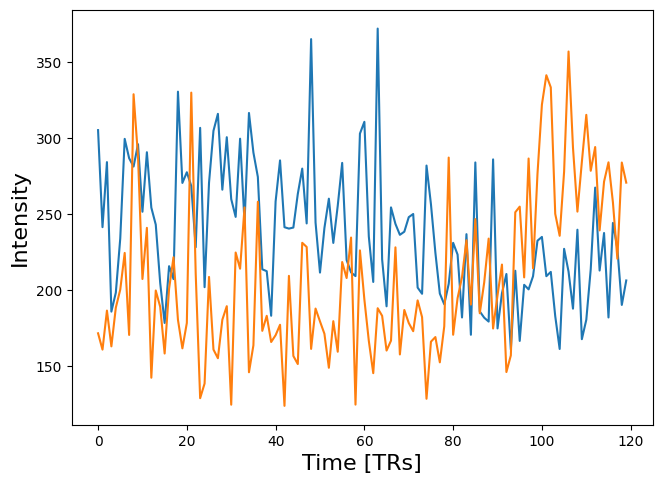

In [26]:
# And now plot a few of these
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.plot(np.rot90(masked_bar1[:1, :]))
plt.plot(np.rot90(masked_bar2[:1, :]))
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
#plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

Average data from 2 sessions

In [27]:
bar_data = (masked_bar1 + masked_bar2)/2

Plot averaged data

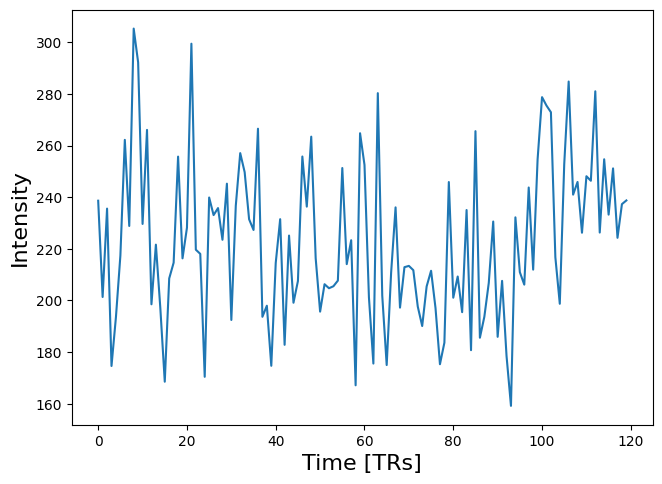

In [28]:
# And now plot a few of these
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.plot(np.rot90(bar_data[:1, :]))
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
#plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

In [29]:
gf = Iso2DGaussianFitter(data=bar_data, model=gg, n_jobs=n_jobs, fit_css=False)


## Gaussian grid fit & Gaussian Iterative Fit

In [30]:
help(Iso2DGaussianFitter.grid_fit)

Help on function grid_fit in module prfpy.fit:

grid_fit(self, ecc_grid, polar_grid, size_grid, verbose=False, n_batches=10, fixed_grid_baseline=None, grid_bounds=None)
    grid_fit
    
    performs grid fit using provided grids and predictor definitions
    
    
    Parameters
    ----------
    ecc_grid : 1D ndarray
        to be filled in by user
    polar_grid : 1D ndarray
        to be filled in by user
    size_grid : 1D ndarray
        to be filled in by user
    verbose : boolean, optional
        print output. The default is False.
    n_batches : int, optional
        The grid fit is performed in parallel over n_batches of units.
        Batch parallelization is faster than single-unit
        parallelization and of sequential computing.
    pos_prfs_only : bool, optional
        Enforce positive PRFs only.
    
    Returns
    -------
    None.



In [31]:
help(Iso2DGaussianFitter.iterative_fit)

Help on function iterative_fit in module prfpy.fit:

iterative_fit(self, rsq_threshold, verbose=False, starting_params=None, bounds=None, args={}, constraints=None, xtol=0.0001, ftol=0.001)
    Generic function for iterative fitting. Does not need to be
    redefined for new models. It is sufficient to define
    `insert_new_model_params` or `grid_fit` in the new model Fitter class,
    or provide explicit `starting_params`
    (see Extend_Iso2DGaussianFitter for examples).
    
    
    Parameters
    ----------
    rsq_threshold : float
        Rsq threshold for iterative fitting. Must be between 0 and 1.
    verbose : boolean, optional
        Whether to print output. The default is False.
    starting_params : ndarray of size [units, model params +1], optional
        Explicit start for iterative fit. The default is None.
    bounds : list of tuples, optional
        Bounds for parameter minimization. The default is None.
    args : dictionary, optional
        Further arguments pa

Grid fit parameters

In [32]:
grid_nr = 30
max_ecc_size = 2*round(max_ecc_deg,2)
size_grid, ecc_grid, polar_grid = max_ecc_size * np.linspace(0.25,1,grid_nr)**2, \
                    max_ecc_size * np.linspace(0.1,1,grid_nr)**2, \
                        np.linspace(0, 2*np.pi, grid_nr)
pos_prfs_only=False

In [33]:
size_grid

array([ 0.8125    ,  0.98929845,  1.18348692,  1.3950654 ,  1.62403389,
        1.87039239,  2.1341409 ,  2.41527943,  2.71380797,  3.02972652,
        3.36303508,  3.71373365,  4.08182224,  4.46730083,  4.87016944,
        5.29042806,  5.72807669,  6.18311534,  6.655544  ,  7.14536266,
        7.65257134,  8.17717004,  8.71915874,  9.27853746,  9.85530618,
       10.44946492, 11.06101367, 11.68995244, 12.33628121, 13.        ])

Iterative fit parameters

In [34]:
rsq_threshold = 0.0005      # float
                            # Rsq threshold for iterative fitting. Must be between 0 and 1.
verbose       = True        # boolean, optional
                            # Whether to print output. The default is False.
# gauss_bounds  = 
# constraints   =
# xtol          =
# ftol          =

Check if grid/iterative fit were run; if not, run them

In [33]:
try:
    try:
        # if pRF parameters have already been extracted
        print("Checking if pRF parameters have already been extracted...")
        f = open(pRF_param_file,'rb')
        print("PRF parameters good to go!")
    except IOError:
        try:
            # if iterative search has already been run
            print("pRF parameters not yet extracted")
            print("Checking if grid and iterative fits have already been run...")
            f = open(iterative_fit_file,'rb')
            gf = pickle.load(f)

            print("Grid and iterative fits have already been run.")
        except IOError:
            print("Iterative fit not yet run.")
            print("Checking if grid fit has been run...")
            # if grid search has already been run
            f = open(grid_fit_file,'rb')
            gf = pickle.load(f)

            print("Grid fit has already been run")

            print("Now running iterative fit")

            gf.iterative_fit(rsq_threshold=rsq_threshold, verbose=verbose)

            f = open(iterative_fit_file, 'wb')
            pickle.dump(gf, f)

except IOError:
    print("Neither grid nor iterative fit yet run...")
    print("Now running grid fit.")
    
    gf.grid_fit(ecc_grid=ecc_grid,
                    polar_grid=polar_grid,
                    size_grid=size_grid,
                    verbose=verbose,
                    n_batches=n_procs)
    f = open(grid_fit_file, 'wb')
    pickle.dump(gf, f)
    f.close()
          
    print("Finished running grid fit.")
    print("Now running iterative fit.")
          
    gf.iterative_fit(rsq_threshold=rsq_threshold, verbose=verbose)

    f = open(iterative_fit_file, 'wb')
    pickle.dump(gf, f)
finally:
    f.close()


Checking if pRF parameters have already been extracted...
PRF parameters good to go!


## Plot results

Extract parameters from iterative fit result

In [34]:
try:
    # if pRF parameters have already been extracted
    f = open(pRF_param_file,'rb')
    x, y, sigma, total_rsq, polar, ecc = pickle.load(f)
except IOError:
    x=gf.iterative_search_params[:,0]
    y=gf.iterative_search_params[:,1]
    sigma=gf.iterative_search_params[:,2]
    total_rsq = gf.iterative_search_params[:,-1]
    
    #Calculate polar angle and eccentricity maps
    polar = np.angle(x + 1j*y)
    ecc = np.abs(x + 1j*y)
    
    f = open(pRF_param_file, 'wb')
    pickle.dump([x, y, sigma, total_rsq, polar, ecc], f)
finally:
    f.close()

In [35]:
max(ecc)

321628.5030131897

In [36]:
x.shape

(69270,)

In [38]:
type(x)

numpy.ndarray

In [40]:
#np.squeeze(masked_meanFunc).shape

(69270,)

In [39]:
type(masked_meanFunc)

numpy.ndarray

Transform back to brain space

In [44]:
unmasked_x     = masker.inverse_transform(x) 
unmasked_y     = masker.inverse_transform(y) 
unmasked_sigma = masker.inverse_transform(sigma) 
unmasked_pol   = masker.inverse_transform(polar) 
unmasked_ecc   = masker.inverse_transform(ecc) 
unmasked_rsq   = masker.inverse_transform(total_rsq) 


In [45]:
#unmasked_meanFunc     = masker.inverse_transform(masked_meanFunc) 


(array([ 11.,  28.,  60.,  80.,  92., 127., 130., 158., 134., 137., 150.,
        172., 191., 200., 173., 181., 190., 181., 172., 222., 223., 198.,
        195., 242., 234., 206., 202., 196., 226., 233., 181., 159., 178.,
        196., 191., 185., 139., 193., 215., 201., 154., 131., 150., 166.,
        187., 170., 147., 134., 137., 178., 192., 168., 138., 108., 106.,
        128., 178., 154., 156., 115.,  84., 100., 161., 170., 159., 109.,
         88.,  64.,  76., 102., 160., 203., 129.,  63.,  42.,  49.,  88.,
        126., 188., 153.,  85.,  38.,  28.,  23.,  58.,  97., 179., 159.,
         59.,  26.,  16.,  12.,  23.,  75., 165., 181.,  48.,  12.,   6.,
          7.]),
 array([0.        , 0.06497308, 0.12994617, 0.19491925, 0.25989234,
        0.32486542, 0.3898385 , 0.45481159, 0.51978467, 0.58475776,
        0.64973084, 0.71470392, 0.77967701, 0.84465009, 0.90962318,
        0.97459626, 1.03956934, 1.10454243, 1.16951551, 1.2344886 ,
        1.29946168, 1.36443476, 1.42940785, 1.

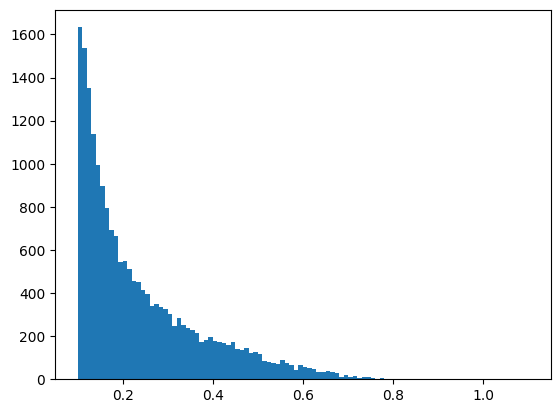

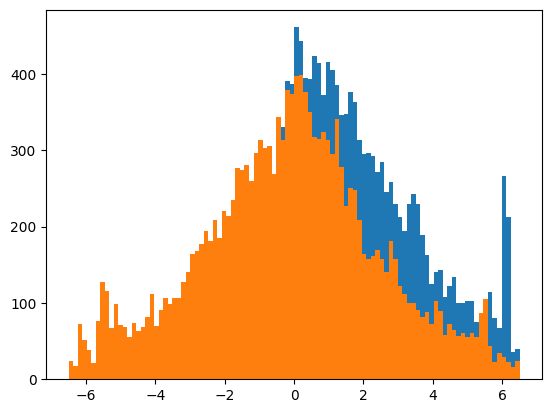

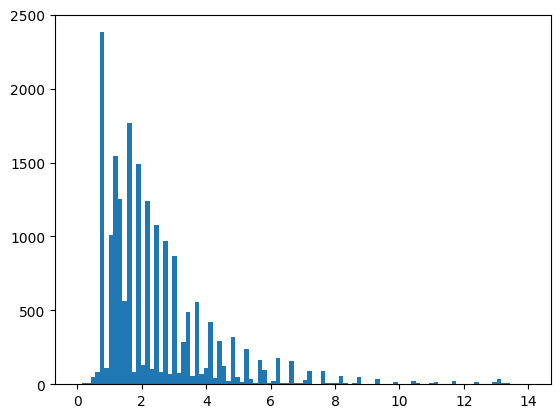

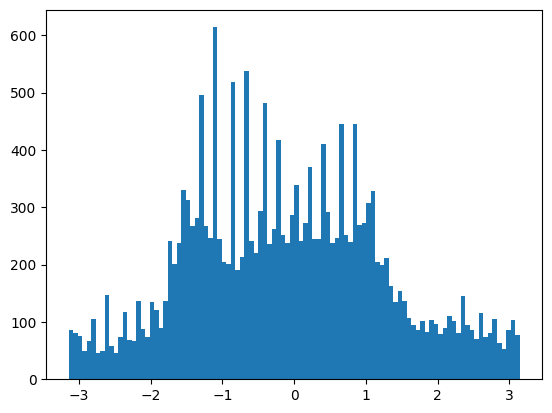

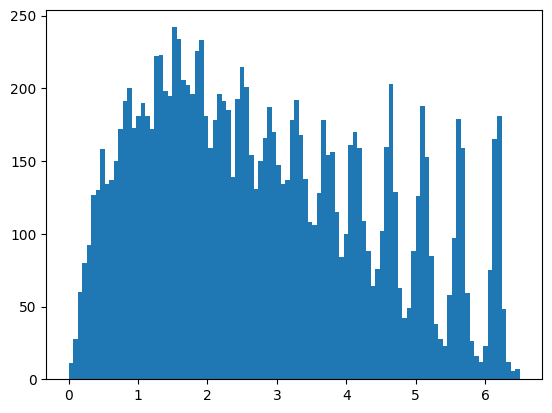

In [53]:
plt.hist(total_rsq, bins=100, range=[0.1,1.1]);
plt.figure()
plt.hist(x[total_rsq>0.1], bins=100, range=[-max_ecc_deg,max_ecc_deg]);
plt.hist(y[total_rsq>0.1], bins=100, range=[-max_ecc_deg,max_ecc_deg]);
plt.figure()
plt.hist(sigma[total_rsq>0.1],bins=100, range=[0,14])
plt.figure()
plt.hist(polar[total_rsq>0.1],bins=100, range=[-np.pi,np.pi])
plt.figure()
plt.hist(ecc[total_rsq>0.1],bins=100, range=[0,max_ecc_deg])
#plt.hist(gfS.iterative_search_params[:,2], bins=100, range=[0,20]);

#plt.stairs(counts, bins)

Visualize x

In [54]:
max(ecc[total_rsq>0.1])

321628.5030131897

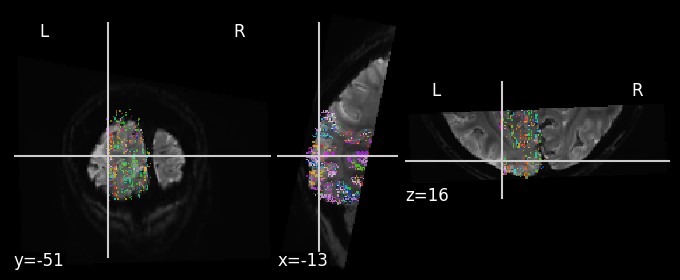

In [55]:
plot_roi(unmasked_pol,meanFunc)

Save Nifti images

In [56]:
nib.save(unmasked_x, opj(prfpy_output_dir, hem_list[hem_id]+'_x.nii'))  
nib.save(unmasked_y, opj(prfpy_output_dir, hem_list[hem_id]+'_y.nii'))  
nib.save(unmasked_sigma, opj(prfpy_output_dir, hem_list[hem_id]+'_sigma.nii'))  
nib.save(unmasked_rsq, opj(prfpy_output_dir, hem_list[hem_id]+'_rsq.nii'))  
nib.save(unmasked_pol, opj(prfpy_output_dir, hem_list[hem_id]+'_pol.nii'))  
nib.save(unmasked_ecc, opj(prfpy_output_dir, hem_list[hem_id]+'_ecc.nii'))  

In [46]:
#nib.save(unmasked_meanFunc, opj(prfpy_output_dir, 'testing_meanFunc.nii'))  


In [ ]:
# min(x)

In [ ]:
# try:
#     # if iterative search has already been run
#     f = open('iterative_fit.pckl','rb')
#     gf = pickle.load(f)
    
#     print("Iterative fit has already been run")
    

# except IOError:
#     print("Running iterative fit")
    
#     gf.iterative_fit(rsq_threshold=rsq_threshold, verbose=verbose)
    
#     f = open('iterative_fit.pckl', 'wb')
#     pickle.dump(gf, f)
#     f.close()
# finally:
#     f.close()



In [ ]:
help(Iso2DGaussianModel)

## Crossvalidate

In [ ]:
help(gf.crossvalidate_fit)

In [ ]:
# gf.crossvalidate_fit(test_data=test_data,
#                      test_stimulus=test_stimulus,
#                      single_hrf=single_hrf)